In [37]:
# === IMPORTS ===

REP_DIR = "/home/graffc/extra/fire_prediction/"
SRC_DIR = REP_DIR + 'src/'
DATA_DIR = REP_DIR + 'data/'

# --- System imports
import numpy as np
import os as os
import datetime as dt
from collections import defaultdict
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# --- Package imports
import evaluation.evaluate_model as evm
import helper.loaders as load
import helper.multidata_wrapper as mdw
import visualization.plotting as vplt
import helper.date_util as du

from models import grid_predictor as gp
from models import poisson_regression as pr
from models import active_ignition_grid as aig
from models import poisson_regression_grid as prg

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [26]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
        
# Build list of file names (based on t_k)
#integrated_cluster_df_fmt = 'processed/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [27]:
# === DATA LOADING ===
X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)
weather_proc_region = load.load_pickle(weather_proc_region_src)

X_active_df = {}
for t_k,f_src in integrated_cluster_df_src_list:
    X_active_df[t_k] = evm.setup_active_fire_data(f_src)
    
BOUNDING_BOX = weather_proc_region.bounding_box

In [29]:
# Non-grid baselines
def only_zero_model(covariates):
    model = aig.ActiveIgnitionGridModel(None, None)
    
    return model

def no_ignition_model_poisson(covariates):
    afm = gp.GridPredictorModel(pr.PoissonRegressionModel(covariates), BOUNDING_BOX)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

In [30]:
# Grid models
def no_ignition_grid_model_poisson(covariates):
    afm = prg.PoissonRegressionGridModel(covariates)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

In [31]:
def build_y(y, t_k_arr):
    y_dict = {}
    for t_k in t_k_arr:
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
        
        # Convert y_new to an xarray dataset
        y_ds = xr.DataArray(y_new, coords={'time': pd.to_datetime(y.dates)}, dims=('y', 'x', 'time'))
        
        y_dict[t_k] = y_ds
        
    return y_dict

def build_x_active(X, t_k_arr):
    X_dict = {}
    for t_k in t_k_arr:
        dates = pd.to_datetime(np.array(X[t_k]['date_local']))
        X_ds = xr.Dataset({'num_det': (('time'), X[t_k]['num_det']),
                           'temperature': (('time'), X[t_k]['temperature']),
                           'humidity': (('time'), X[t_k]['humidity']),
                           'wind': (('time'), X[t_k]['wind']),
                           'rain': (('time'), X[t_k]['rain']),
                           'lat_centroid': (('time'), X[t_k]['lat_centroid']),
                           'lon_centroid': (('time'), X[t_k]['lon_centroid']),
                           'num_det_target': (('time'), X[t_k]['num_det_target'])},
                          {'time': dates})
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,None))
    return X_dict

In [32]:
fill_n_days = 5

def fill_missing_value(data, date_ind):                                                    
    """
    Try to replace with closest prev day in range [1, fill_n_days].                                                

    If no non-nan value is found, replaces with mean of all values at the given lat/lon.                           
    """ 
    for day_offset in range(1,fill_n_days+1):                                                                 
        new_date_ind = date_ind - day_offset                                                                       

        if new_date_ind < 0:                                                                                       
            break                                                                                                  

        val = data[:, :, new_date_ind]                                                                 

        if not np.any(np.isnan(val)):                                                                                      
            return val                                                                                             

    return np.nanmean(data[:, :, :], axis=2)

def get_date_index(weather_data, target_datetime):
        date_ind = np.searchsorted(weather_data.dates, target_datetime, side='left')

        # Check if left or right element is closer
        if date_ind != 0:
            date_ind_left, date_ind_curr = date_ind-1, date_ind

            dist_left = abs((weather_data.dates[date_ind_left] - target_datetime).total_seconds())
            dist_curr = abs((weather_data.dates[date_ind_curr] - target_datetime).total_seconds())
            
            if dist_left < dist_curr:
                date_ind = date_ind_left

        return date_ind
    
def get_weather_variables(vals,weather_data, target_datetime, covariates):                                                             
    # Get date index
    date_ind = get_date_index(weather_data, target_datetime)                                                  

    #vals = []
    for key in covariates:                                                                           
        data = weather_data[key].values                                                                            
        val = data[:, :, date_ind]                                                                 

        if np.any(np.isnan(val)):
            val = fill_missing_value(data, date_ind)                                        

        #vals.append(val)                                                                                           
        vals[key].append(val)    

In [229]:
def create_cell_encoding(group_size, shape):
    data = []
    
    num_rows = int(np.ceil(shape[0]/(1.*group_size)))
    num_cols = int(np.ceil(shape[1]/(1.*group_size)))

    enc_all = np.zeros((num_rows,num_cols,shape[0],shape[1],shape[2]))
    
    # fill enc for each cell
    for i in range(shape[0]):
        for j in range(shape[1]):
            enc_all[int(i/group_size),int(j/group_size),i,j,:]=1
    
    # split into columns
    for i in range(num_rows):
        for j in range(num_cols):
            enc = enc_all[i,j]
            data.append(('cell_%d_%d'%(i,j),enc))
    return data
    
def build_x_grid(X, y, t_k_arr):
    X_dict = {}
    for t_k in t_k_arr:
        
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
        
        # Build grid of weather
        vals = defaultdict(list)
        for date in Y_detection_c.dates:
            time = 14
            date += du.INC_ONE_DAY * t_k # For row t, store weather(t+k)
            target_datetime = dt.datetime.combine(date, dt.time(time, 0, 0, tzinfo=du.TrulyLocalTzInfo(153, du.round_to_nearest_quarter_hour)))
            
            get_weather_variables(vals, X, target_datetime, ['temperature','humidity','wind','rain'])

        for k,v in vals.iteritems():
            vals[k] = np.rollaxis(np.array(v), 0, 3)  
        
        dates = pd.to_datetime(np.array(y.dates))
        X_ds = xr.Dataset({'num_det': (('y','x','time'), y.values),
                           'num_det_target': (('y', 'x', 'time'), y_new),
                           'temperature': (('y','x','time'), vals['temperature']),
                           'humidity': (('y','x','time'), vals['humidity']),
                           'wind': (('y','x','time'), vals['wind']),
                           'rain': (('y','x','time'), vals['rain'])},
                          {'time': dates})
                       
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,None))
        
        print 'T_k=%d' % t_k,
    print
    return X_dict

In [64]:
y_grid_dict = build_y(Y_detection_c, T_K_ARR)
X_active_dict = build_x_active(X_active_df, T_K_ARR)
X_grid_dict = build_x_grid(weather_proc_region, Y_detection_c, T_K_ARR)

In [232]:
# Add encoding pairs (for cell/region biases)
encoding_pairs = create_cell_encoding(8, Y_detection_c.values.shape)
for k,v in X_grid_dict.iteritems():
    for name,enc in encoding_pairs:
        v[0].update({name: (('y','x','time'), enc)})

In [258]:
param_dict = {'None': [],
              'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain']}

param_dict_grid = {'None': [],
              'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain'],
              'All + Biases': [n for n in X_grid_dict[1][0].data_vars]}
YEARS_TEST = range(2007,2008)              

In [130]:
# Test baselines
results_only_zero, models_only_zero = evm.evaluate_model_params(only_zero_model, {'None': []}, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_no_ig, models_no_ig = evm.evaluate_model_params(no_ignition_model_poisson, param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
35.3452439308


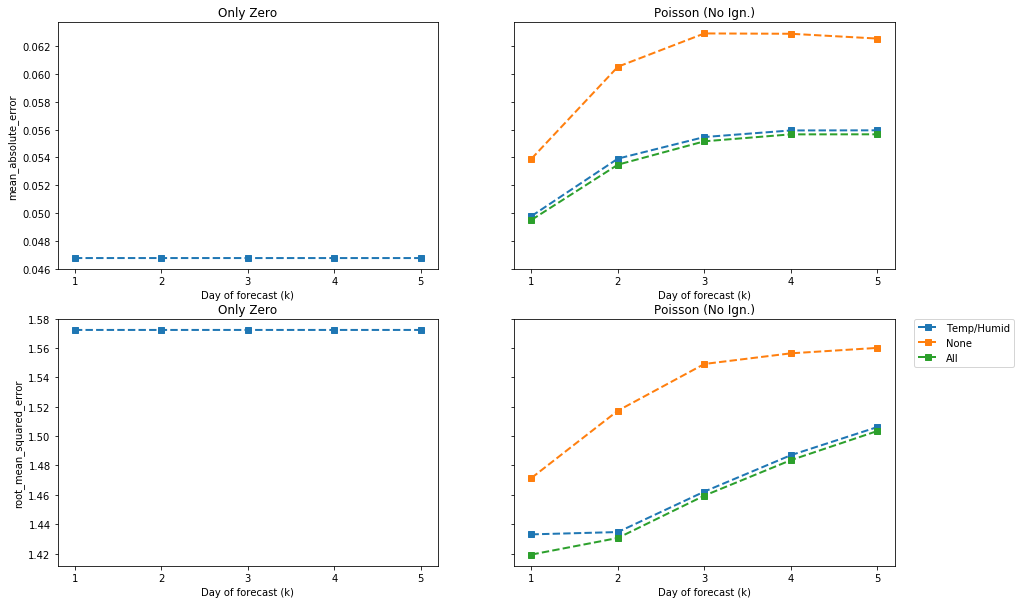

In [131]:
vplt.plot_results_grid([(results_only_zero[1], 'Only Zero'), (results_no_ig[1], 'Poisson (No Ign.)')], T_K_ARR)

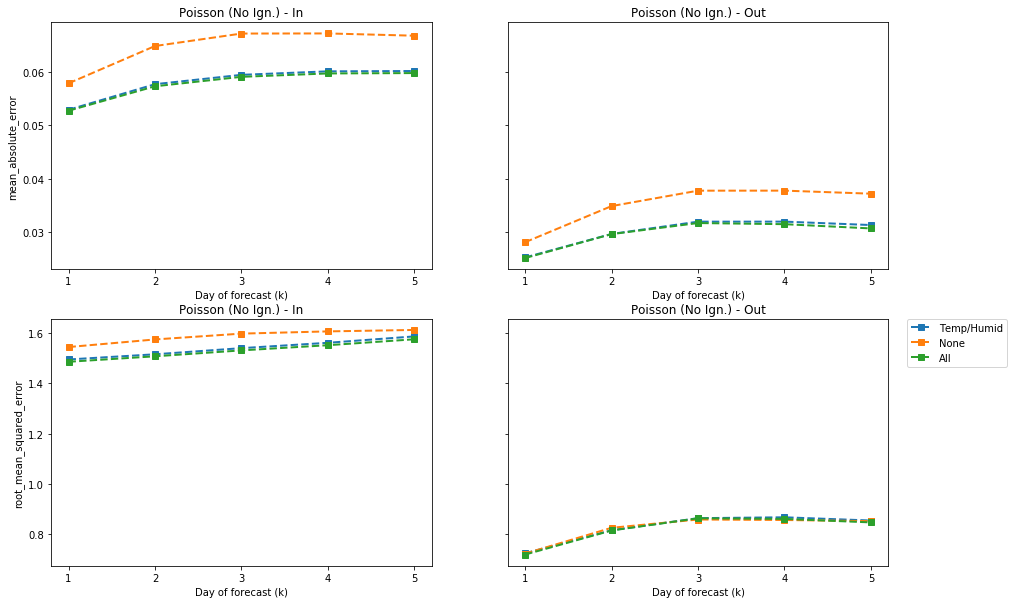

In [90]:
vplt.plot_results_grid([(results_no_ig[0], 'Poisson (No Ign.) - In'), (results_no_ig[1], 'Poisson (No Ign.) - Out')], T_K_ARR)

In [260]:
param_dict_grid = {'All + Biases': [n for n in X_grid_dict[1][0].data_vars]}

In [261]:
results_no_ig_grid, models_no_ig_grid = evm.evaluate_model_params(no_ignition_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


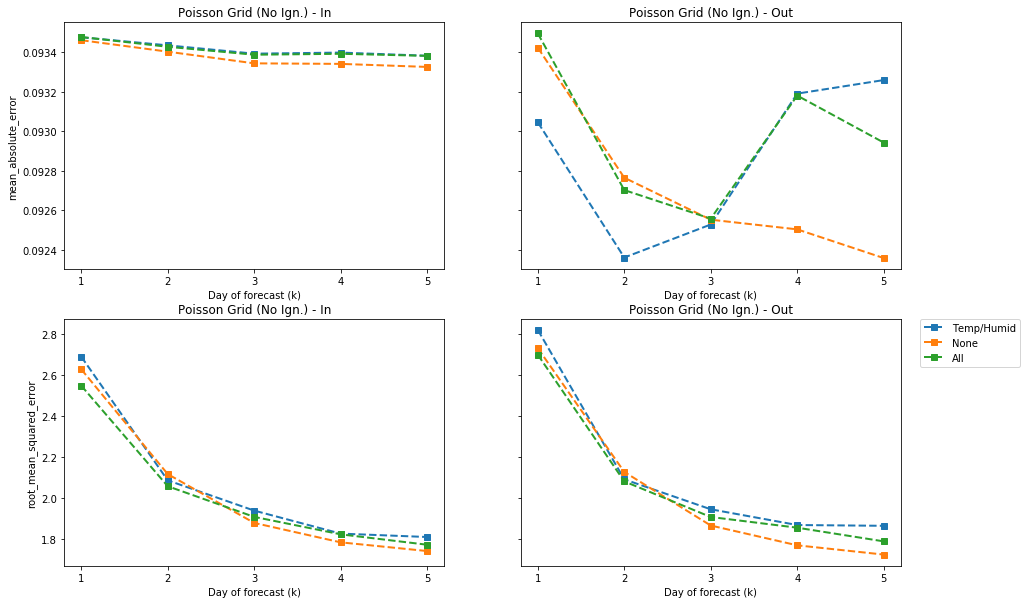

In [98]:
vplt.plot_results_grid([(results_no_ig_grid[0], 'Poisson Grid (No Ign.) - In'), (results_no_ig_grid[1], 'Poisson Grid (No Ign.) - Out')], T_K_ARR)

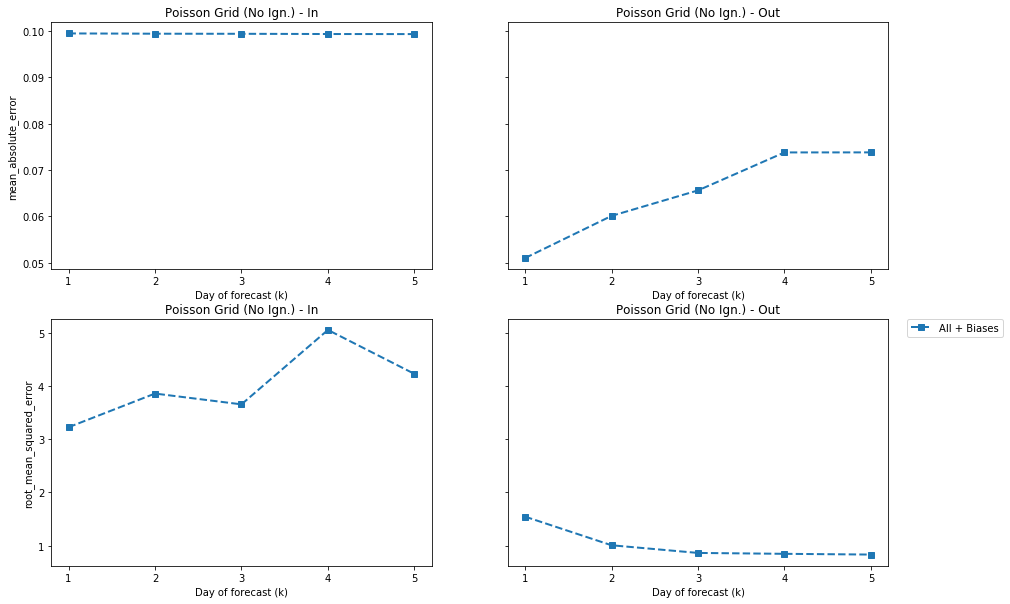

In [328]:
vplt.plot_results_grid([(results_no_ig_grid[0], 'Poisson Grid (No Ign.) - In'), (results_no_ig_grid[1], 'Poisson Grid (No Ign.) - Out')], T_K_ARR)